# CHLA MODIS PIPELINE WALKTHROUGH

In [1]:
import os
import numpy as np
import toolbox

#import toolbox.IcesheetCHANGES as changes
import toolbox.chla.chlCHANGES as changes
import toolbox.chla.chl_collection as collection
import toolbox.grid_generation as grid
import toolbox.initiation.grid_construction as grid_construction
import toolbox.data_handling as data 


import netCDF4 as nc
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

import toolbox.reprojection as reprojection

# import toolbox.store_nc as store

## Download data
...skipping for now-- assuming data is downloaded via the download notebooks...

In [2]:
# Print the possible data sets
print(collection.print_collections())

Available collections: 

SeaWiFS Ocean Color Level 3 Mapped Chlorophyll Concentration
Short name: SeaWiFS Ocean Color

Aqua MODIS Global Mapped Chlorophyll (CHL) Data
Short name: Aqua MODIS

None


In [3]:
collection_key = 'Aqua MODIS'

project_folder = '/Users/tara/Documents/SJSU/MLML/Projects/CHANGES/Examples'
# data_folder = '/Volumes/Seagate/aquaMODIS/4km_20020704_20230131'
data_folder = '/Volumes/Seagate/CHANGES/data_repository/CHL/'   #Quarterly_Stacks/MODIS'

Skipping downloading for now...
use the oceancolor download script and point your data folder to the data. 

In [4]:
# Create the object and print some attributes
collection_id = collection.collection(collection_key)
print('Collection ID: ', collection_id)

CC = changes.chlCHANGES(project_folder, data_folder)
CC.print_attributes()
print('\n')

# DC.print_collection_info()
CC.collection_info(collection_key)

Collection ID:  aquadata
Metadata path:	 /Users/tara/Documents/SJSU/MLML/Projects/CHANGES/Examples/Metadata


Collection ID:  aquadata
Collection long name:	 Aqua MODIS Global Mapped Chlorophyll (CHL) Data
Collection short name:	 Aqua MODIS
Data type:		 Chlorophyll
Download path:		 /Volumes/Seagate/CHANGES/data_repository/CHL/Quarterly_Stacks/MODIS/Greenland/Chlorophyll/Aqua MODIS/Data


In [5]:
# get the bounds of the ice sheet and create a grid
# save the grid as a shapefile
grid.create_grid(CC)

Chlorophyll grid dictionary generated for 50km resolution
Shapefile saved to /Users/tara/Documents/SJSU/MLML/Projects/CHANGES/Examples/Metadata/Greenland/Chlorophyll/Grid_50km


In [6]:
# Increase CELL grid resolution (meters)
CC.posting = 100

In [7]:
import glob
# get a list of files in data_folder
file_list = glob.glob(data_folder + '/*.nc')
file_list.sort()
print(file_list)

[]


In [7]:
# # LOAD IN OUR DATA STACK
# # output_file = '/Volumes/Seagate/aquaMODIS/4km_20020704_20230131/test_small_2 test.nc'
# # output_file = '/Volumes/Seagate/CHANGES/data_repository/CHL/Annual_Stacks/MODIS/annual_batch_2002.nc'
# # output_file = '/Volumes/Seagate/CHANGES/data_repository/CHL/Annual_Stacks/MODIS/annual_batch_2003.nc'




# ds = nc.Dataset(output_file)

# # lons = ds.variables['x'][:]
# # lats = ds.variables['y'][:]
# # chla = ds.variables['chlor_a'][:]

# # print the variables in the netcdf file
# print(ds.variables.keys())
# lons = ds.variables['lon'][:]
# lats = ds.variables['lat'][:]
# chla = ds.variables['chlor_a'][:]
# time = ds.variables['time'][:]

# ds.close()

# # print(lons, lats, chla)

dict_keys(['lat', 'lon', 'chlor_a', 'time'])


In [27]:
file = '/Volumes/Seagate/CHANGES/data_repository/CHL/Annual_Stacks/MODIS/annual_batch_2003.nc'

file = file_list[0]

ds = nc.Dataset(file)

# lons = ds.variables['x'][:]
# lats = ds.variables['y'][:]
# chla = ds.variables['chlor_a'][:]

# print the variables in the netcdf file
# print(ds.variables.keys())
lons = ds.variables['lon'][:]
lats = ds.variables['lat'][:]
chla = ds.variables['chlor_a'][:]
time = ds.variables['time'][:]


ds.close()

In [ ]:
print(time[0])

print(time[-1])

20031231


In [11]:
# Specify the grid of interest and give it a unique nickname to avoid file overwrites
CC.nickname = 'test_2002'
min_row = 22
min_col = 7
max_row = 22
max_col = 7

In [12]:
# Store the cells of interest as an attribute of the IC object
grid_of_interest = [min_row, min_col, max_row, max_col]
grid.store_cells(CC, grid_of_interest)

Cells:  ['r_22_c_07']


In [13]:
CC.cells


['r_22_c_07']

In [11]:
# TODO: put this in a loop for all cells in a region

# output folder for the stack
output_folder =  os.path.join(CC.data_folder, 'Output', CC.icesheet_name, CC.region_name)
output_file = os.path.join(output_folder, CC.short_name + "_stack.nc")
print(output_file)

# look at the first cell
cell_ID = CC.cells[0]
print(cell_ID)

# get the bounds of the cell
CC.extents = grid.grid_cell_ID_to_cell_bounds(cell_ID, CC.grid_dict)
print(CC.extents)

/Volumes/Seagate/aquaMODIS/4km_20020704_20230131/Output/Greenland/Aqua MODIS_stack.nc
r_22_c_07
[-302925, -2284425, -252925, -2234425]


In [12]:
# buffered_extents = [CC.extents[0]-(CC.posting*10), CC.extents[1]-(CC.posting*10), CC.extents[2]+(CC.posting*10), CC.extents[3]+(CC.posting*10)]
buffer = CC.posting*100
buffered_extents = [CC.extents[0]-buffer, CC.extents[1]-buffer, CC.extents[2]+buffer, CC.extents[3]+buffer]
print(buffered_extents)
CC.extents = buffered_extents

[-312925, -2294425, -242925, -2224425]


In [13]:
# TODO: this would go in the loop too

grid_construction.create_grid_from_extents(CC)
print(CC.chl_grid_x)
print(CC.chl_grid_x.shape)

# print(CC.chl_grid_y)
print(CC.chl_grid_y.shape)

[-312925 -312825 -312725 -312625 -312525 -312425 -312325 -312225 -312125
 -312025 -311925 -311825 -311725 -311625 -311525 -311425 -311325 -311225
 -311125 -311025 -310925 -310825 -310725 -310625 -310525 -310425 -310325
 -310225 -310125 -310025 -309925 -309825 -309725 -309625 -309525 -309425
 -309325 -309225 -309125 -309025 -308925 -308825 -308725 -308625 -308525
 -308425 -308325 -308225 -308125 -308025 -307925 -307825 -307725 -307625
 -307525 -307425 -307325 -307225 -307125 -307025 -306925 -306825 -306725
 -306625 -306525 -306425 -306325 -306225 -306125 -306025 -305925 -305825
 -305725 -305625 -305525 -305425 -305325 -305225 -305125 -305025 -304925
 -304825 -304725 -304625 -304525 -304425 -304325 -304225 -304125 -304025
 -303925 -303825 -303725 -303625 -303525 -303425 -303325 -303225 -303125
 -303025 -302925 -302825 -302725 -302625 -302525 -302425 -302325 -302225
 -302125 -302025 -301925 -301825 -301725 -301625 -301525 -301425 -301325
 -301225 -301125 -301025 -300925 -300825 -300725 -3

In [14]:
# Reproject the grid to the desired output CRS

inputCRS = 4326
outputCRS = 3413

xx, yy = np.meshgrid(lons, lats)

polygon_array = np.array([xx.flatten(), yy.flatten()]).T

output_polygon = reprojection.reproject_polygon(polygon_array,inputCRS,outputCRS)

x = output_polygon[:,0].reshape(xx.shape)
y = output_polygon[:,1].reshape(yy.shape)


print(x.shape, y.shape, chla.shape)   
print(x.shape, y.shape, chla.shape)   
print(CC.extents)
# 


(4320, 8640) (4320, 8640) (174, 4320, 8640)
(4320, 8640) (4320, 8640) (174, 4320, 8640)
[-312925, -2294425, -242925, -2224425]


In [15]:
print(CC.chl_grid_x)

[-312925 -312825 -312725 -312625 -312525 -312425 -312325 -312225 -312125
 -312025 -311925 -311825 -311725 -311625 -311525 -311425 -311325 -311225
 -311125 -311025 -310925 -310825 -310725 -310625 -310525 -310425 -310325
 -310225 -310125 -310025 -309925 -309825 -309725 -309625 -309525 -309425
 -309325 -309225 -309125 -309025 -308925 -308825 -308725 -308625 -308525
 -308425 -308325 -308225 -308125 -308025 -307925 -307825 -307725 -307625
 -307525 -307425 -307325 -307225 -307125 -307025 -306925 -306825 -306725
 -306625 -306525 -306425 -306325 -306225 -306125 -306025 -305925 -305825
 -305725 -305625 -305525 -305425 -305325 -305225 -305125 -305025 -304925
 -304825 -304725 -304625 -304525 -304425 -304325 -304225 -304125 -304025
 -303925 -303825 -303725 -303625 -303525 -303425 -303325 -303225 -303125
 -303025 -302925 -302825 -302725 -302625 -302525 -302425 -302325 -302225
 -302125 -302025 -301925 -301825 -301725 -301625 -301525 -301425 -301325
 -301225 -301125 -301025 -300925 -300825 -300725 -3

In [16]:
# Santity Check-- win (confirmed with https://epsg.io)
print(lons[500], lats[500], chla[0,500,500])
print(x[500,500], y[500,500], chla[0,500,500])

-159.14583 69.145836 --
-2083566.5 934025.06 --


# Interpolation ! 

In [17]:
import numpy as np
from scipy.interpolate import griddata

# Assuming you have your data loaded as x, y, and chla
# Also assuming you have x_grid and y_grid defined

# Define the bounds of your cell in 3413
# minx, miny, maxx, maxy = -302925, -2284425, -252925, -2234425
minx, miny, maxx, maxy = CC.extents

# Crop the data to the bounds of your cell
mask = (x >= minx) & (x <= maxx) & (y >= miny) & (y <= maxy)
x_cropped = x[mask]
y_cropped = y[mask]
chla_cropped = chla[:, mask]

# Create a meshgrid for the cell
xx, yy = np.meshgrid(CC.chl_grid_x, CC.chl_grid_y)

# Reshape the meshgrid to match the dimensions of the data
xx = xx.flatten()
yy = yy.flatten()

# Initialize an empty array for the interpolated data
interpolated_chla = np.zeros((chla.shape[0], len(CC.chl_grid_x), len(CC.chl_grid_y)))

# Interpolate the chla data to this grid for each time step
for t in range(chla.shape[0]):
    interpolated_chla[t] = griddata((x_cropped, y_cropped), chla_cropped[t], (xx, yy), method='linear').reshape(len(CC.chl_grid_x), len(CC.chl_grid_y))

# The interpolated_chla array will contain your interpolated data
print(interpolated_chla.shape)


(174, 700, 700)


In [18]:
og_extents = [CC.extents[0]+buffer, CC.extents[1]+buffer, CC.extents[2]-buffer, CC.extents[3]-buffer]
minx, miny, maxx, maxy = og_extents

interpolated_chla_cropped = interpolated_chla[:, (CC.chl_grid_y >= miny) & (CC.chl_grid_y <= maxy), :][:, :, (CC.chl_grid_x >= minx) & (CC.chl_grid_x <= maxx)]
CC.chl_grid_x = CC.chl_grid_x[(CC.chl_grid_x >= minx) & (CC.chl_grid_x <= maxx)]
CC.chl_grid_y = CC.chl_grid_y[(CC.chl_grid_y >= miny) & (CC.chl_grid_y <= maxy)]

interpolated_chla_cropped[interpolated_chla_cropped < 0] = np.nan

In [19]:
# interpolated_chla[interpolated_chla < 0] = np.nan

In [20]:
print(chla.shape)
print(interpolated_chla.shape)
print(interpolated_chla_cropped.shape)
print(x_cropped.shape)
print(CC.chl_grid_x.shape)
print(CC.chl_grid_y.shape)


(174, 4320, 8640)
(174, 700, 700)
(174, 501, 501)
(637,)
(501,)
(501,)


In [21]:
import xarray as xr

# Assuming you have your data loaded as interpolated_chla and coordinates x and y

# Create an xarray dataset
ds = xr.Dataset(
    {
        "chla": (["time", "x", "y"], interpolated_chla_cropped),
    },
    coords={
        "x": CC.chl_grid_x,
        "y": CC.chl_grid_y,
        "time": np.arange(chla.shape[0]),
    },
)

# Save the dataset to a NetCDF file
ds.to_netcdf("interpolated_chl_stack_modis_2003.nc")

# Print a confirmation message
print("Data saved to file")


Data saved to file


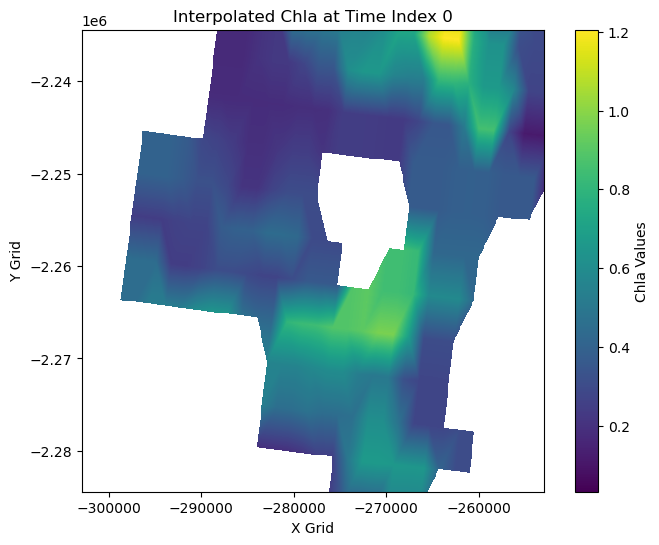

In [22]:
import matplotlib.pyplot as plt

# Assuming you have your data loaded as interpolated_chla

# Choose a specific time index to visualize
time_index = 0

# Plot the interpolated chla data
plt.figure(figsize=(8, 6))
plt.imshow(interpolated_chla_cropped[time_index], origin='lower', extent=(min(CC.chl_grid_x), max(CC.chl_grid_x), min(CC.chl_grid_y), max(CC.chl_grid_y)))
plt.colorbar(label='Chla Values')

# format xticks as plain


plt.xlabel('X Grid')
plt.ylabel('Y Grid')
plt.title(f'Interpolated Chla at Time Index {time_index}')
plt.show()


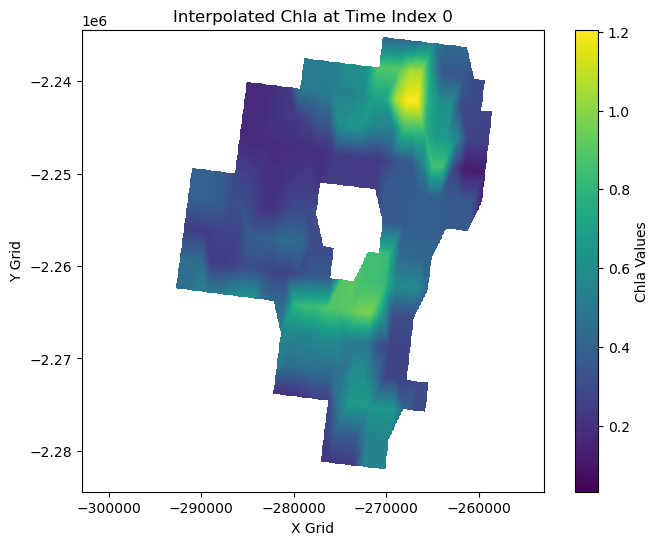

In [168]:
import matplotlib.pyplot as plt

# Assuming you have your data loaded as interpolated_chla

# Choose a specific time index to visualize
time_index = 0

# Plot the interpolated chla data
plt.figure(figsize=(8, 6))
plt.imshow(interpolated_chla_cropped[time_index], origin='lower', extent=(min(CC.chl_grid_x), max(CC.chl_grid_x), min(CC.chl_grid_y), max(CC.chl_grid_y)))
plt.colorbar(label='Chla Values')

# format xticks as plain


plt.xlabel('X Grid')
plt.ylabel('Y Grid')
plt.title(f'Interpolated Chla at Time Index {time_index}')
plt.show()


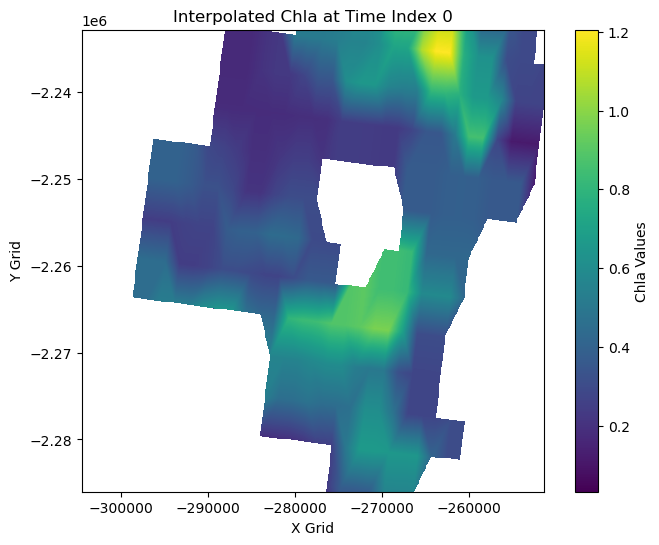

In [135]:
import matplotlib.pyplot as plt

# Assuming you have your data loaded as interpolated_chla

# Choose a specific time index to visualize
time_index = 0

# Plot the interpolated chla data
plt.figure(figsize=(8, 6))
plt.imshow(interpolated_chla_cropped[time_index], origin='lower', extent=(min(x_cropped), max(x_cropped), min(y_cropped), max(y_cropped)))
plt.colorbar(label='Chla Values')

# format xticks as plain


plt.xlabel('X Grid')
plt.ylabel('Y Grid')
plt.title(f'Interpolated Chla at Time Index {time_index}')
plt.show()


# Now let's look at seawifs

In [169]:
collection_key = 'SeaWiFS Ocean Color'

project_folder = '/Users/tara/Documents/SJSU/MLML/Projects/CHANGES/Examples'
data_folder = '/Volumes/Seagate/SeaWiFs/chla/daily'

In [170]:
# Create the object and print some attributes
collection_id = collection.collection(collection_key)
print('Collection ID: ', collection_id)

CC = changes.chlCHANGES(project_folder, data_folder)
CC.print_attributes()
print('\n')

# DC.print_collection_info()
CC.collection_info(collection_key)

Collection ID:  seawifsdata
Metadata path:	 /Users/tara/Documents/SJSU/MLML/Projects/CHANGES/Examples/Metadata


Collection ID:  seawifsdata
Collection long name:	 SeaWiFS Ocean Color Level 3 Mapped Chlorophyll Concentration
Collection short name:	 SeaWiFS Ocean Color
Data type:		 Chlorophyll
Download path:		 /Volumes/Seagate/SeaWiFs/chla/daily/Greenland/Chlorophyll/SeaWiFS Ocean Color/Data


In [171]:
# get the bounds of the ice sheet and create a grid
# save the grid as a shapefile
grid.create_grid(CC)

Chlorophyll grid dictionary generated for 50km resolution
Shapefile saved to /Users/tara/Documents/SJSU/MLML/Projects/CHANGES/Examples/Metadata/Greenland/Chlorophyll/Grid_50km


In [172]:
# Increase CELL grid resolution (meters)
CC.posting = 100

In [176]:
# LOAD IN OUR DATA STACK
output_file = '/Volumes/Seagate/SeaWiFs/chla/daily/SEASTAR_SEAWIFS_GAC.20100806.L3m.DAY.CHL.chlor_a.9km.nc'

ds = nc.Dataset(output_file)

# get info about ds
# print(ds)
print(ds.variables.keys())
# print(ds.variables['chlor_a'])


lons = ds.variables['lon'][:]
lats = ds.variables['lat'][:]
chla = ds.variables['chlor_a'][:]

# ds.close()

# print(lons, lats, chla)

dict_keys(['chlor_a', 'lat', 'lon', 'palette'])


In [185]:
print(lons.shape, lats.shape, chla.shape)

(4320,) (2160,) (2160, 4320)


In [177]:
# Specify the grid of interest and give it a unique nickname to avoid file overwrites
CC.nickname = 'test_small_8'
min_row = 22
min_col = 7
max_row = 22
max_col = 7

In [178]:
# Store the cells of interest as an attribute of the IC object
grid_of_interest = [min_row, min_col, max_row, max_col]
grid.store_cells(CC, grid_of_interest)

Cells:  ['r_22_c_07']


In [179]:
CC.cells


['r_22_c_07']

In [180]:
# TODO: put this in a loop for all cells in a region

# output folder for the stack
output_folder =  os.path.join(CC.data_folder, 'Output', CC.icesheet_name, CC.region_name)
output_file = os.path.join(output_folder, CC.short_name + "_stack.nc")
print(output_file)

# look at the first cell
cell_ID = CC.cells[0]
print(cell_ID)

# get the bounds of the cell
CC.extents = grid.grid_cell_ID_to_cell_bounds(cell_ID, CC.grid_dict)
print(CC.extents)

/Volumes/Seagate/SeaWiFs/chla/daily/Output/Greenland/SeaWiFS Ocean Color_stack.nc
r_22_c_07
[-302925, -2284425, -252925, -2234425]


In [181]:
# buffered_extents = [CC.extents[0]-(CC.posting*10), CC.extents[1]-(CC.posting*10), CC.extents[2]+(CC.posting*10), CC.extents[3]+(CC.posting*10)]
buffer = CC.posting*100
buffered_extents = [CC.extents[0]-buffer, CC.extents[1]-buffer, CC.extents[2]+buffer, CC.extents[3]+buffer]
print(buffered_extents)
CC.extents = buffered_extents

[-312925, -2294425, -242925, -2224425]


In [182]:
# TODO: this would go in the loop too

grid_construction.create_grid_from_extents(CC)
print(CC.chl_grid_x)
print(CC.chl_grid_x.shape)

# print(CC.chl_grid_y)
print(CC.chl_grid_y.shape)

[-312925 -312825 -312725 -312625 -312525 -312425 -312325 -312225 -312125
 -312025 -311925 -311825 -311725 -311625 -311525 -311425 -311325 -311225
 -311125 -311025 -310925 -310825 -310725 -310625 -310525 -310425 -310325
 -310225 -310125 -310025 -309925 -309825 -309725 -309625 -309525 -309425
 -309325 -309225 -309125 -309025 -308925 -308825 -308725 -308625 -308525
 -308425 -308325 -308225 -308125 -308025 -307925 -307825 -307725 -307625
 -307525 -307425 -307325 -307225 -307125 -307025 -306925 -306825 -306725
 -306625 -306525 -306425 -306325 -306225 -306125 -306025 -305925 -305825
 -305725 -305625 -305525 -305425 -305325 -305225 -305125 -305025 -304925
 -304825 -304725 -304625 -304525 -304425 -304325 -304225 -304125 -304025
 -303925 -303825 -303725 -303625 -303525 -303425 -303325 -303225 -303125
 -303025 -302925 -302825 -302725 -302625 -302525 -302425 -302325 -302225
 -302125 -302025 -301925 -301825 -301725 -301625 -301525 -301425 -301325
 -301225 -301125 -301025 -300925 -300825 -300725 -3

In [186]:
# Reproject the grid to the desired output CRS

inputCRS = 4326
outputCRS = 3413

xx, yy = np.meshgrid(lons, lats)

polygon_array = np.array([xx.flatten(), yy.flatten()]).T

output_polygon = reprojection.reproject_polygon(polygon_array,inputCRS,outputCRS)

x = output_polygon[:,0].reshape(xx.shape)
y = output_polygon[:,1].reshape(yy.shape)


print(x.shape, y.shape, chla.shape)   
print(x.shape, y.shape, chla.shape)   
print(CC.extents)
# 


(2160, 4320) (2160, 4320) (2160, 4320)
(2160, 4320) (2160, 4320) (2160, 4320)
[-312925, -2294425, -242925, -2224425]


In [187]:
import numpy as np
from scipy.interpolate import griddata

# Assuming you have your data loaded as x, y, and chla
# Also assuming you have x_grid and y_grid defined

# Define the bounds of your cell in 3413
# minx, miny, maxx, maxy = -302925, -2284425, -252925, -2234425
minx, miny, maxx, maxy = CC.extents

# Crop the data to the bounds of your cell
mask = (x >= minx) & (x <= maxx) & (y >= miny) & (y <= maxy)
x_cropped = x[mask]
y_cropped = y[mask]
chla_cropped = chla[mask]

# Create a meshgrid for the cell
xx, yy = np.meshgrid(CC.chl_grid_x, CC.chl_grid_y)

# Reshape the meshgrid to match the dimensions of the data
xx = xx.flatten()
yy = yy.flatten()

# Initialize an empty array for the interpolated data
interpolated_chla = np.zeros((chla.shape[0], len(CC.chl_grid_x), len(CC.chl_grid_y)))

# Interpolate the chla data to this grid for each time step
# for t in range(chla.shape[0]):
interpolated_chla = griddata((x_cropped, y_cropped), chla_cropped, (xx, yy), method='linear').reshape(len(CC.chl_grid_x), len(CC.chl_grid_y))

# The interpolated_chla array will contain your interpolated data
print(interpolated_chla.shape)


(700, 700)


In [189]:
# og_extents = [CC.extents[0]+buffer, CC.extents[1]+buffer, CC.extents[2]-buffer, CC.extents[3]-buffer]
# minx, miny, maxx, maxy = og_extents

interpolated_chla_cropped = interpolated_chla[(CC.chl_grid_y >= miny) & (CC.chl_grid_y <= maxy), :][:, (CC.chl_grid_x >= minx) & (CC.chl_grid_x <= maxx)]
CC.chl_grid_x = CC.chl_grid_x[(CC.chl_grid_x >= minx) & (CC.chl_grid_x <= maxx)]
CC.chl_grid_y = CC.chl_grid_y[(CC.chl_grid_y >= miny) & (CC.chl_grid_y <= maxy)]

interpolated_chla_cropped[interpolated_chla_cropped < 0] = np.nan

In [190]:
interpolated_chla[interpolated_chla < 0] = np.nan

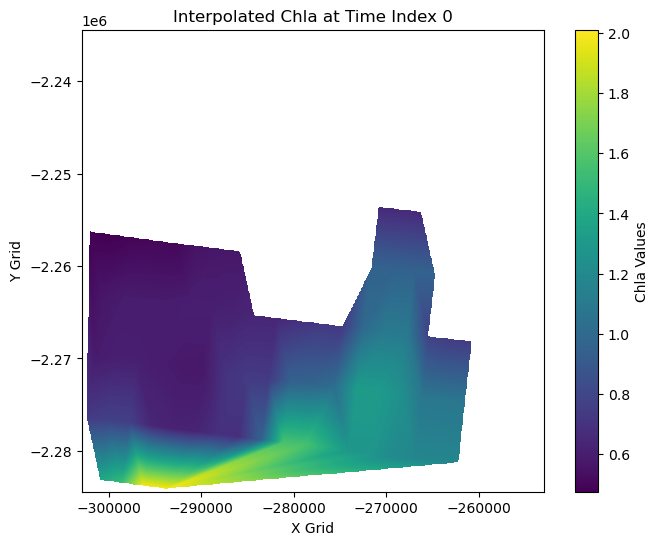

In [191]:
import matplotlib.pyplot as plt

# Assuming you have your data loaded as interpolated_chla

# Choose a specific time index to visualize
# time_index = 0

# Plot the interpolated chla data
plt.figure(figsize=(8, 6))
plt.imshow(interpolated_chla, origin='lower', extent=(min(CC.chl_grid_x), max(CC.chl_grid_x), min(CC.chl_grid_y), max(CC.chl_grid_y)))
plt.colorbar(label='Chla Values')

# format xticks as plain


plt.xlabel('X Grid')
plt.ylabel('Y Grid')
plt.title(f'Interpolated Chla at Time Index {time_index}')
plt.show()


In [ ]:
import xarray as xr

# Assuming you have your data loaded as interpolated_chla and coordinates x and y

# Create an xarray dataset
ds = xr.Dataset(
    {
        "chla": (["time", "x", "y"], interpolated_chla),
    },
    coords={
        "x": CC.chl_grid_x,
        "y": CC.chl_grid_y,
        "time": np.arange(chla.shape[0]),
    },
)

# Save the dataset to a NetCDF file
ds.to_netcdf("interpolated_chl_stack_test2.nc")

# Print a confirmation message
print("Data saved to interpolated_chl_stack_test.nc")


Data saved to interpolated_chl_stack_test.nc
